# Traffic Signs

Ref: https://www.kaggle.com/saadhaxxan/germantrafficsigns

Detecting Street Signs is one of the most important tasks in Self Driving Cars.This dataset is a benchmark in Street signs and symbols including 43 different classes. Classifying road symbols is the aim of this dataset.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
import numpy as np
import sys
import matplotlib.pyplot as plt

In [0]:
import tempfile
import os
import tensorflow as tf
import pandas as pd
import io
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Dense, Dropout, MaxPool1D, MaxPool2D, LSTM, Flatten, Reshape
import time
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

from matplotlib import rcParams
rcParams['font.size'] = 15

In [0]:
#%tensorflow_version 2.x
#import tensorflow as tf
#%tensorflow_version 2.1.0
#tf.__version__

In [0]:
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Data:

Import signnames and data into dataframes

In [0]:
root_dir = "/content/drive/My Drive/Assignment One/Datasets/germantrafficsigns/"
df_signnames = pd.read_csv(root_dir+'signnames.csv')

Class labels to be predicted:

In [59]:
df_signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


We have 43 classes to predict

In [0]:
class_names = df_signnames.SignName

Import train, validation and test data

In [0]:
import pickle as pik
train_data_dic = pik.Unpickler(open(root_dir + 'train.p','rb')).load()
valid_data_dic = pik.Unpickler(open(root_dir + 'valid.p','rb')).load()
test_data_dic = pik.Unpickler(open(root_dir + 'test.p','rb')).load()

In [62]:
for x,y in train_data_dic.items(): 
  print("train data size :")
  print(x, y.shape)
for x,y in valid_data_dic.items(): 
  print(x, y.shape)
for x,y in test_data_dic.items(): 
  print(x, y.shape)

train data size :
coords (34799, 4)
train data size :
labels (34799,)
train data size :
features (34799, 32, 32, 3)
train data size :
sizes (34799, 2)
coords (4410, 4)
labels (4410,)
features (4410, 32, 32, 3)
sizes (4410, 2)
sizes (12630, 2)
coords (12630, 4)
features (12630, 32, 32, 3)
labels (12630,)


In [0]:
train_x = train_data_dic['features']
train_y = train_data_dic['labels']

valid_x = valid_data_dic['features']
valid_y = valid_data_dic['labels']

test_x = test_data_dic['features']
test_y = test_data_dic['labels']

Shape of the data:

In [64]:
print("Train data shape ", train_x.shape)
print("Validation data shape ", valid_x.shape)
print("Test data shape ", test_x.shape)

Train data shape  (34799, 32, 32, 3)
Validation data shape  (4410, 32, 32, 3)
Test data shape  (12630, 32, 32, 3)


In [65]:
df_signnames.iloc[0]['SignName']

'Speed limit (20km/h)'

# Visualization:

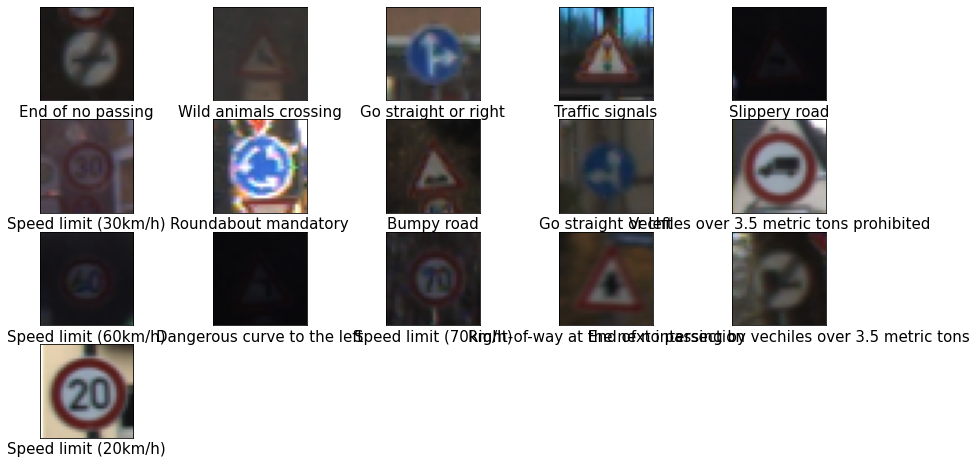

In [66]:
plt.figure(figsize=(15,10))
prev_label = -1
j=-1
for i in range(10000):
    if(prev_label != train_y[i]):
      j =j+1;
      plt.subplot(5,5,j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_x[i])
      plt.xlabel(df_signnames.iloc[train_y[i]]['SignName'])
      prev_label = train_y[i]
plt.show()

### GrayScale:

In [0]:
from skimage.color import rgb2gray
train_gray_x = rgb2gray(train_x)
valid_gray_x = rgb2gray(valid_x)
test_gray_x = rgb2gray(test_x)

In [68]:
train_gray_x.shape

(34799, 32, 32)

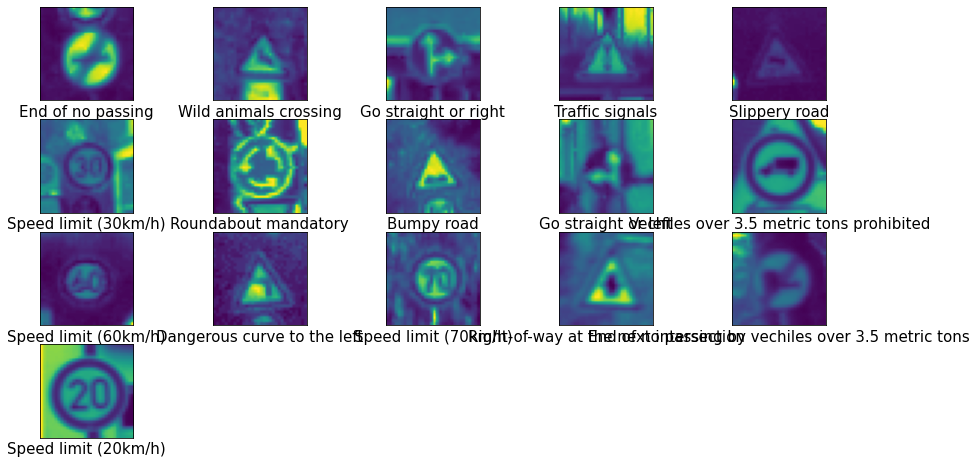

In [69]:
plt.figure(figsize=(15,10))
prev_label = -1
j=-1
for i in range(10000):
    if(prev_label != train_y[i]):
      j =j+1;
      plt.subplot(5,5,j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_gray_x[i])
      plt.xlabel(df_signnames.iloc[train_y[i]]['SignName'])
      prev_label = train_y[i]
plt.show()

### Target Distribution:

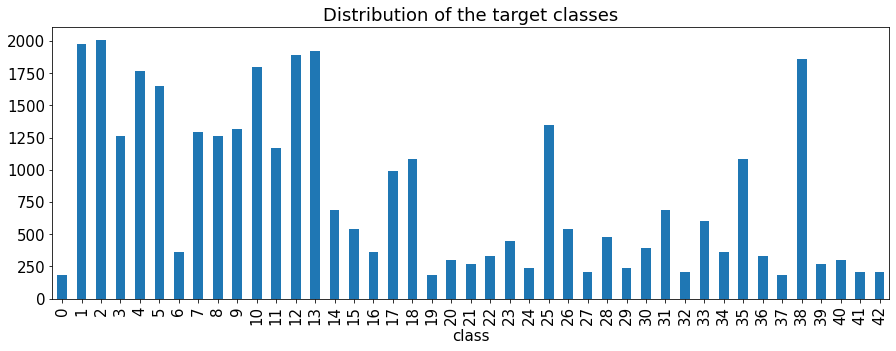

In [70]:
pd.Series(train_y).reset_index(name='class').groupby('class')['index'].count().plot(kind='bar', figsize=(15,5))
plt.title('Distribution of the target classes');

In [0]:
num_classes = 43

# Scaling

In [0]:
#scaling
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255
valid_x = valid_x.astype('float32')/255

In [0]:
#scalling grayscale images
train_gray_x = train_gray_x.astype('float32') / 255
test_gray_x = test_gray_x.astype('float32') / 255
valid_gray_x = valid_gray_x.astype('float32')/255


# Combined Model



In [74]:
model = Sequential()
model.add(Conv2D(28, (3,3), activation='relu', input_shape=(32,32, 3)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(28, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 28)        784       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        16192     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 28)        16156     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        16192     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 64)         

In [75]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
t = time.time()
model_acc = model.fit(train_x, train_y, epochs=200, validation_data=(valid_x, valid_y), callbacks=[early_stopping]) 
t = np.round(time.time() - t, 2)
print("time Taken to run the script ", t)

Epoch 1/200
1088/1088 [==============================] - 10s 9ms/step - loss: 1.4617 - accuracy: 0.5690 - val_loss: 0.3215 - val_accuracy: 0.9138
Epoch 2/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.2804 - accuracy: 0.9136 - val_loss: 0.1270 - val_accuracy: 0.9658
Epoch 3/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.1562 - accuracy: 0.9534 - val_loss: 0.0979 - val_accuracy: 0.9730
Epoch 4/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.1135 - accuracy: 0.9662 - val_loss: 0.0855 - val_accuracy: 0.9787
Epoch 5/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0910 - accuracy: 0.9729 - val_loss: 0.0893 - val_accuracy: 0.9773
Epoch 6/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0826 - accuracy: 0.9763 - val_loss: 0.0657 - val_accuracy: 0.9803
Epoch 7/200
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0652 - accuracy: 0.9803 - val_loss: 0.1001 - val_a

In [76]:
predictions = model.predict(test_x) 
result = model.evaluate(test_x, test_y, batch_size=64)
print(result)

198/198 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.9721
[0.36762574315071106, 0.972050666809082]


In [77]:
model.layers[12]

In [0]:
from tensorflow.keras import Model
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[12].output)
intermediate_layer_train_output = intermediate_layer_model.predict(train_x)
intermediate_layer_val_output = intermediate_layer_model.predict(valid_x)
intermediate_layer_test_output = intermediate_layer_model.predict(test_x)

In [0]:
#Taking the output an intermediate layer of CNN as the input of KNeighbours Classifier
this_train_x = intermediate_layer_train_output[0:20000]
this_train_y = train_y[0:20000]
this_test_x = intermediate_layer_test_output[0:10000]
this_test_y = test_y[0:10000]

In [0]:
neighbors = np.arange(3,15)
rmse_val = []
train_rmse_val = []
for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(this_train_x, this_train_y)
    pred = knn.predict(this_test_x) 
    error = sqrt(mean_squared_error(this_test_y,pred))
    rmse_val.append(error)
    pred = knn.predict(this_train_x) 
    error = sqrt(mean_squared_error(this_train_y,pred))
    train_rmse_val.append(error)

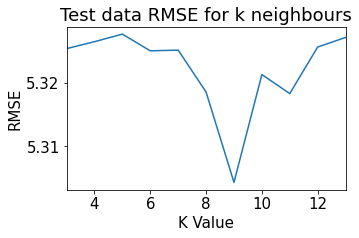

In [86]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(3,15), rmse_val)
plt.title("Test data RMSE for k neighbours")
plt.xlim(3,13)
plt.xlabel("K Value")
plt.ylabel("RMSE");

### Using 5 neighbours to generate final model


In [0]:
this_train_x = intermediate_layer_train_output
this_valid_x = intermediate_layer_val_output
this_test_x = intermediate_layer_test_output

In [88]:
t = time.time()
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(this_train_x, train_y)
print("Traning Accuracy: ", knn.score(this_train_x, train_y))
print("Validation Accuracy: ", knn.score(this_valid_x, valid_y))
print("Test Accuracy: ", knn.score(this_test_x, test_y))
t = np.round(time.time() - t, 2)
print("Time taken to run the model: ", t)

Traning Accuracy:  0.999856317710279
Validation Accuracy:  0.9866213151927438
Test Accuracy:  0.971575613618369
Time taken to run the model:  13.24
